# OpenPack Dataset - Data Visualization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-pack/openpack-toolkit/blob/main/samples/OpenPack_DataVisualization.ipynb)

This notebook shows how to visualize the OpenPack dataset data and file formats.
OpenPack team is developping a python package named [`openpack-tooklit` (link)](https://github.com/open-pack/openpack-toolkit) to accelerate the usability of this dataset.
Through this tutorial, we hope to help you get an overview of the dataset and get familiar with our data and tools.

## Table of Contents
1. Download the OpenPack Dataset
1. Visualize the OpenPack Dataset
    1. Annotation Data (`openpack-operatsion`)
    1. IMU Data (`atr-qags`)
    1. Keypoints (`kinect-2d-kpt`)


## Note
In this tutorial we to use `openpack-tooklit/samples/` as a dataset directory in order to use sample data in the openpack-toolkit repo.
Please change this path to fit your envirinment.

## [1] Donwload OpenPack Dataset

OpenPack dataset can be downloaded from [zenodo](https://doi.org/10.5281/zenodo.5909086), an online repository for Open Science.
OpenPack data is split into several subdirectories (by subject and by sensor stream) and individual zipped files are available in zenodo. You can choose to download, unzip and integrate them one by one.
Here, we will show an easier way to download and setup the files directly using the `openpack-toolkit (optk)`.
The first step is to install `openpack-tooklit` via pip and download the dataset.

### 1-1: Install `openpack-tooklit (optk)` from PyPI

In the command line run

In [1]:
! pip install openpack-toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=98f7efa5d38dfc6600271eb8f5b1c9ff2336deeae3b161f40e5cb899d3bd6c1b
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


After installation, import the toolkit and verify the package version.

In [2]:
import openpack_toolkit as optk
print("version", optk.__version__)

version 1.1.0


### 1-2: Download OpenPack Dataset

In this notebook, we will visualize sample data in the [openpack-toolkit](https://github.com/open-pack/openpack-toolkit/tree/main/samples) repo.
You can download a sample dataset with `git clone`.

In [3]:
! git clone https://github.com/open-pack/openpack-toolkit.git

Cloning into 'openpack-toolkit'...
remote: Enumerating objects: 2288, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 2288 (delta 96), reused 143 (delta 86), pack-reused 2062
Receiving objects: 100% (2288/2288), 55.31 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (1283/1283), done.
Updating files: 100% (226/226), done.


If you want to download the full dataset, please see ["Download Dataset"](https://github.com/open-pack/openpack-toolkit/tree/main#download-dataset) section in the readme.

## [2] Load and Visualize Data in OpenPack Dataset

In OpenPack dataset, all configurations including file locations are managed by [`omegaconf` (link)](https://omegaconf.readthedocs.io/en/latest/), a YAML-based hierarchical configuration system.
`openpack-toolkit` provides python's data class instances (defined [here](https://github.com/open-pack/openpack-toolkit/tree/main/openpack_toolkit/configs)) and can be used to get the file location.


Config YAML files are stored [here](https://github.com/open-pack/openpack-toolkit/tree/main/configs).
Detailed information can be obtained by reading these config files.


To get the desired variable using the config object `openpack-toolkit` utilizes OmegaConf's variable interpolation feature.
We recommend reading [this document (official docs of omegaconf)](https://omegaconf.readthedocs.io/en/latest/usage.html#variable-interpolation) to deepen your understanding.

First step is importing required libraries

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import json
import openpack_toolkit as optk
from omegaconf import DictConfig, OmegaConf, open_dict
from openpack_toolkit.utils.notebook import noglobal

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns
sns.set("notebook", "whitegrid", font_scale=1.5)

The root config object is defined like this.
**Make sure to set `path/openpack.rootdir` appropriately for your environment.**

In [23]:
cfg = OmegaConf.create({
    "user": optk.configs.users.U0209,
    "session": None,
    "path": {
        "openpack": {
            "version": "v1.0.0",
            "rootdir": "/content/openpack-toolkit/samples/openpack/${.version}", # Edit here
        },
    },
    "dataset": {
        "annotation": None,
        "stream": None,
    }
})

In [24]:
print(OmegaConf.to_yaml(cfg))

user:
  id: 209
  name: U0209
  sessions:
    S0100:
      duration: 36m54s
      end: '2022-03-29T10:30:53+09:00'
      start: '2022-03-29T09:53:59+09:00'
    S0200:
      duration: 29m33s
      end: '2022-03-29T11:24:53+09:00'
      start: '2022-03-29T10:55:20+09:00'
    S0300:
      duration: 28m52s
      end: '2022-03-29T12:21:31+09:00'
      start: '2022-03-29T11:52:39+09:00'
    S0400:
      duration: 29m29s
      end: '2022-03-29T14:01:17+09:00'
      start: '2022-03-29T13:31:48+09:00'
    S0500:
      duration: 23m22s
      end: '2022-03-29T14:48:44+09:00'
      start: '2022-03-29T14:25:22+09:00'
session: null
path:
  openpack:
    version: v1.0.0
    rootdir: /content/openpack-toolkit/samples/openpack/${.version}
dataset:
  annotation: null
  stream: null



## 2-A: Annotation Data (openpack-operations)

- [docs](https://github.com/open-pack/openpack-toolkit/blob/main/docs/ANNOTATION.md#1-openpack_operations)
- [config](https://github.com/open-pack/openpack-toolkit/blob/main/configs/dataset/annotation/openpack-operations.yaml)

The definitions for activity classes and file formats are described [here](https://github.com/open-pack/openpack-toolkit/blob/main/docs/ANNOTATION.md).
In this section, we explore the activity set named `OPENPACK_OPERATIONS` (key = `openpack-operations`).
This activity set consists of 10 work operations and its data is saved in CSV format.
In the OpenPack challenge, a task for participants is to localize these activities.

In [25]:
print(OmegaConf.to_yaml(OmegaConf.create(optk.OPENPACK_OPERATIONS)))

- id: 100
  name: Picking
  version: v3.0.0
  is_ignore: false
  category: null
  event: null
- id: 200
  name: Relocate Item Label
  version: v3.2.2
  is_ignore: false
  category: null
  event: null
- id: 300
  name: Assemble Box
  version: v3.2.2
  is_ignore: false
  category: null
  event: null
- id: 400
  name: Insert Items
  version: v3.2.2
  is_ignore: false
  category: null
  event: null
- id: 500
  name: Close Box
  version: v3.2.2
  is_ignore: false
  category: null
  event: null
- id: 600
  name: Attach Box Label
  version: v3.2.2
  is_ignore: false
  category: null
  event: null
- id: 700
  name: Scan Label
  version: v3.2.2
  is_ignore: false
  category: null
  event: null
- id: 800
  name: Attach Shipping Label
  version: v3.2.2
  is_ignore: false
  category: null
  event: null
- id: 900
  name: Put on Back Table
  version: v3.2.2
  is_ignore: false
  category: null
  event: null
- id: 1000
  name: Fill out Order
  version: v3.2.2
  is_ignore: false
  category: null
  even

First, we get the path to the annotation data of U0209-S0500 using omegconf.
The path to the annotation data is defined in `optk.configs.dataset.annotations.OPENPACK_OPERATIONS_1HZ_ANNOTATION.path`.
`OPENPACK_OPERATIONS_1HZ_ANNOTATION` contains metadata of the annotation file. This files contains the operation and actions labels sampled at 1 Hz.

As it can be seen, values in the config contain placeholders and they will be interpolated when you access these attributes.
So you need to set the required variables (`session`, etc) first and access the config to get the desired path.

In [26]:
# NOTE: Path template is defined in `path` attribute.
print("kind:", optk.configs.datasets.annotations.OPENPACK_OPERATIONS_1HZ_ANNOTATION.kind)
print("name:", optk.configs.datasets.annotations.OPENPACK_OPERATIONS_1HZ_ANNOTATION.name)
print(OmegaConf.to_yaml(optk.configs.datasets.annotations.OPENPACK_OPERATIONS_1HZ_ANNOTATION.path))

kind: dataset/annotation/csv/sequence
name: openpack-operations-1hz
dir: ${path.openpack.rootdir}/${user.name}/annotation/openpack-operations-1hz
fname: ${session}.csv



In [27]:
# Set parameters to the config object.
# NOTE: user.name is already defined above. See [2]
cfg.dataset.annotation = optk.configs.datasets.annotations.OPENPACK_OPERATIONS_1HZ_ANNOTATION
cfg.session = "S0500"

path = Path(
    cfg.dataset.annotation.path.dir,
    cfg.dataset.annotation.path.fname,
)
print(path)

/content/openpack-toolkit/samples/openpack/v1.0.0/U0209/annotation/openpack-operations-1hz/S0500.csv


In [28]:
# Load CSV file
df = pd.read_csv(path)

In [29]:
df

,unixtime,user,session,box,id
0,1648531522000,U0209,S0500,1,100
1,1648531523000,U0209,S0500,1,100
2,1648531524000,U0209,S0500,1,100
3,1648531525000,U0209,S0500,1,100
4,1648531526000,U0209,S0500,1,100
...,...,...,...,...,...
1399,1648532921000,U0209,S0500,20,900
1400,1648532922000,U0209,S0500,20,900
1401,1648532923000,U0209,S0500,20,900
1402,1648532924000,U0209,S0500,20,900


The imported DataFrame contains unixtime, operation class IDs and so on.
`unixtime` is important in the OpenPack dataset. When using multiple data streams, it is possible to use the `unixtime` to align the sequences.

Next, we visualize loaded annotation data.

In [30]:
@noglobal()
def plot_openpack_operations(df: pd.DataFrame, xlim=None, figsize=(30, 7), OPENPACK_OPERATIONS=optk.ActSet(optk.OPENPACK_OPERATIONS)):
    seq_len = len(df)

    df["cls_idx"] = OPENPACK_OPERATIONS.convert_id_to_index(df["id"])

    df_head = df.drop_duplicates(["user", "session", "box"], keep="first")
    df_tail = df.drop_duplicates(["user", "session", "box"], keep="last")
    df_box = pd.DataFrame({
        "box": df_head["box"],
        "start": df_head.index,
        "end": df_tail.index,
    }).reset_index(drop=True)

    # == Plot ==
    fig, ax0 = plt.subplots(1, 1, figsize=figsize)
    xloc = np.arange(seq_len)

    ax0.plot(xloc, df["cls_idx"], lw=3)
    for index, row in df_box.iterrows():
        ax0.fill_between([row.start, row.end], 0, 11, color=f"C{row.box%10}", alpha=0.2)
        ax0.text(
            row.start, 11, f"Box{row.box:0=2}",
            fontweight="bold", color="black",
        )

    xticks = np.arange(0, seq_len, 60 * 2)
    xticks_minor = np.arange(0, seq_len, 30)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 60)
    ax0.set_xticks(xticks_minor, minor=True)
    ax0.set_xlabel("Time [min]", fontweight="bold")
    if xlim is None:
        ax0.set_xlim([0, seq_len])
    else:
        ax0.set_xlim(xlim)

    yticklabels = [k for k in OPENPACK_OPERATIONS.get_ids()]
    ax0.set_yticks(np.arange(len(OPENPACK_OPERATIONS)))
    ax0.set_yticklabels(yticklabels)
    ax0.set_ylabel("Class ID")

    ax0.grid(True, which="minor", linestyle=":")

    ax0.set_title(f"OPENPACK OPERATIONS", fontsize="x-large", fontweight="bold")

    fig.tight_layout()
    return fig

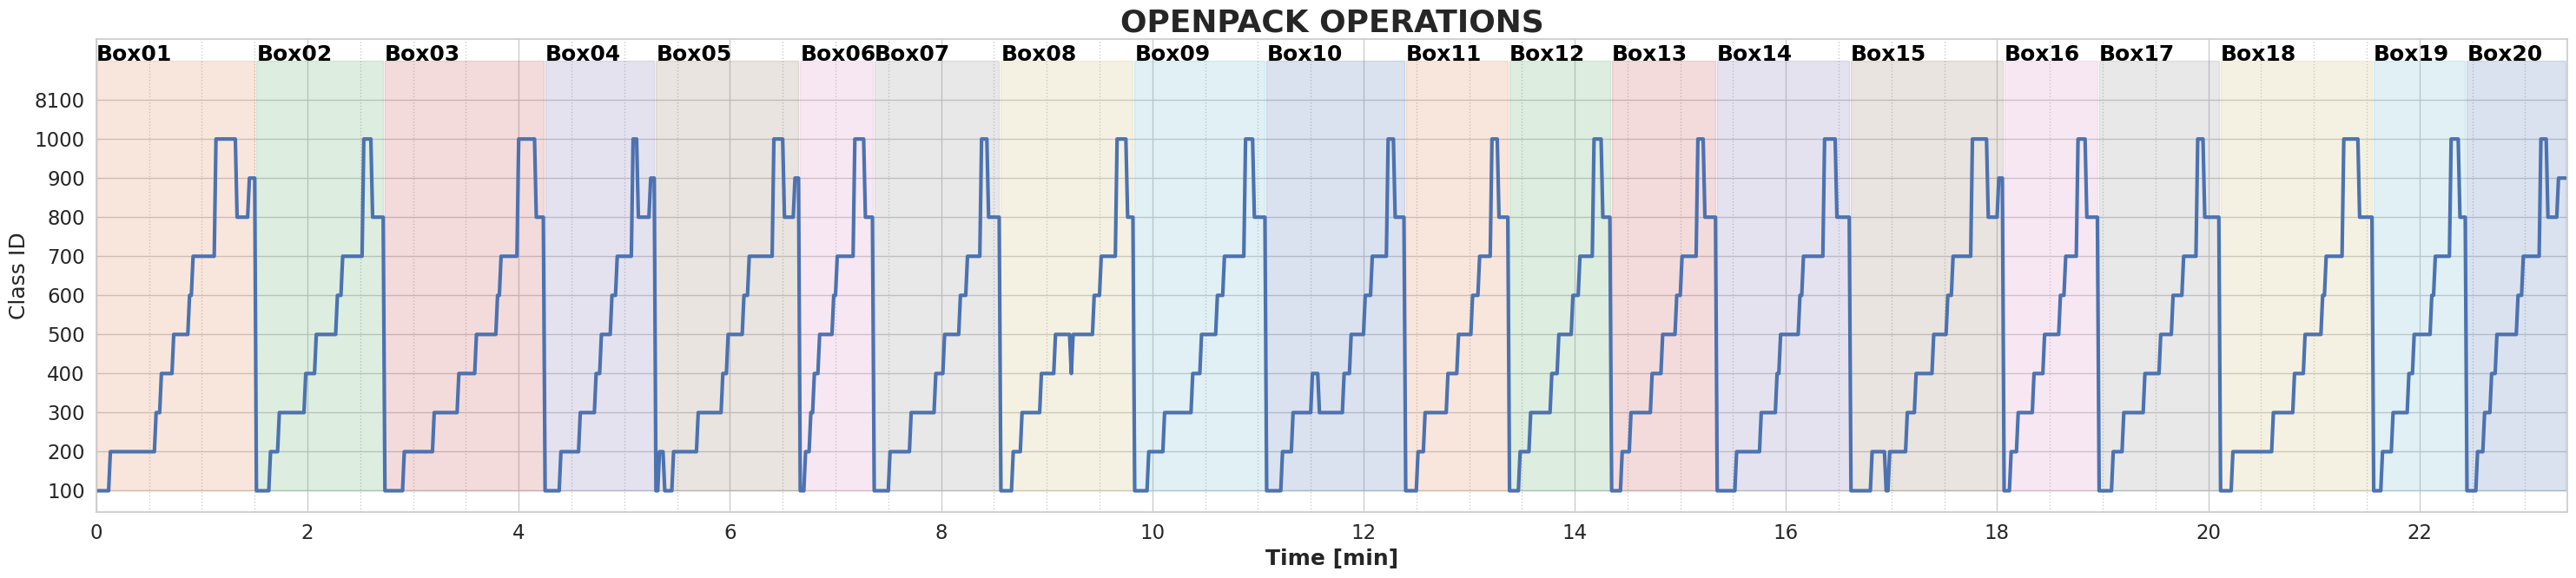

In [31]:
fig = plot_openpack_operations(df)
fig.show()

### Tips: Resample Label Sequence

The sampling rate of operation labels is 1 Hz, but sensor data streams have different sampling rates.
It is posible to get any label sequence in the desired sampling interval with [`optk.data.load_and_resample_operation_labels()` (API Docs)](https://open-pack.github.io/openpack-toolkit/openpack_toolkit/data/index.html#openpack_toolkit.data.load_and_resample_operation_labels). This function returns activity IDs and indexes at the given timestamps (unixtime).


In [32]:
""" Examples from https://github.com/open-pack/openpack-toolkit/blob/f12cd1e9b1c497d7f10558bf8149a04cd71cc781/tests/data/test_dataloader.py
"""
cfg.session = "S0500"
path = Path(
    cfg.dataset.annotation.path.dir,
    cfg.dataset.annotation.path.fname,
)
print(f"input path: {path} (exists={path.exists()})")

unixtimes = np.array([
    1634885794000,
    1634885794200,  # Resampling 1
    1634885794400,  # Resampling 2
    1634885794600,  # Resampling 3
    1634885794800,  # Resampling 4
    1634885795000,
    1634885796000,
    1634885798000,  # Next Action
])


df_annot = optk.data.load_and_resample_operation_labels(path, unixtimes, classes=optk.ActSet(optk.OPENPACK_OPERATIONS))

input path: /content/openpack-toolkit/samples/openpack/v1.0.0/U0209/annotation/openpack-operations-1hz/S0500.csv (exists=True)


In [33]:
df_annot

,unixtime,annot_time,user,session,box,act_id,act_idx
0,1634885794000,0,U0209,S0500,0,8100,10
1,1634885794200,0,U0209,S0500,0,8100,10
2,1634885794400,0,U0209,S0500,0,8100,10
3,1634885794600,0,U0209,S0500,0,8100,10
4,1634885794800,0,U0209,S0500,0,8100,10
5,1634885795000,0,U0209,S0500,0,8100,10
6,1634885796000,0,U0209,S0500,0,8100,10
7,1634885798000,0,U0209,S0500,0,8100,10


## 2-B: Acceratation, Gyroscope, and Quaterinon from IMU (`atr-qags`)

- [Docs](https://github.com/open-pack/openpack-toolkit/blob/main/docs/DATA_STREAM.md#1-atr-qags)

Subjects wore 4 IMU sensors ([ATR-TSND151](http://www.atr-p.com/products/TSND121_151.html)).
These sensors recorded acceratation, gyroscope, and quaterinon sequences. These data can be used to predict work operations in the challenge.
The data is saved as CSV file.

Let's load and visualize data from atr01 (IMU sensor attached to the right wrist). The procedure is almost the same as that for annotation described above. (note how we changed the conf key from 'datasets.annotations.OPENPACK_OPERATIONS_ANNOTATION' to 'datasets.streams.ATR_QAGS_STREAM')

In [34]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.ATR_QAGS_STREAM))

kind: dataset/stream/imu
name: atr-qags
metadata:
  labels:
    app: openpack
    version: 1.0.0
    sensorType: IMU
path:
  dir: ${path.openpack.rootdir}/${user.name}/atr
  fname: ${device}/${session}.csv
frameRate: 30
devices:
- atr01
- atr02
- atr03
- atr04
acc: true
gyro: true
quat: true
nodes: ???



In [35]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.ATR_QAGS_STREAM
cfg.session = "S0500"
cfg.device = "atr01"

path = Path(
    cfg.dataset.stream.path.dir,
    cfg.dataset.stream.path.fname,
)
print(path)

/content/openpack-toolkit/samples/openpack/v1.0.0/U0209/atr/atr01/S0500.csv


In [36]:
# Load CSV file
df = pd.read_csv(path)

In [37]:
df

,unixtime,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,quat_w,quat_x,quat_y,quat_z
0,1648531521000,0.3795,0.9069,0.1097,0.67,1.76,-0.24,0.5312,-0.6406,-0.2343,0.5000
1,1648531521030,0.3728,0.9221,0.1092,0.36,0.60,-1.21,0.5312,-0.6406,-0.2343,0.5000
2,1648531521060,0.3946,0.9261,0.0999,-0.06,-1.21,-1.28,0.5312,-0.6406,-0.2343,0.5000
3,1648531521090,0.3924,0.9162,0.0982,0.30,0.54,-0.48,0.5312,-0.6406,-0.2343,0.5000
4,1648531521120,0.3835,0.9146,0.1037,0.42,0.42,-0.42,0.5312,-0.6406,-0.2343,0.5000
...,...,...,...,...,...,...,...,...,...,...,...
46795,1648532924850,0.7608,1.1198,-0.1293,-82.86,31.52,-84.81,-0.4218,-0.3750,-0.5000,0.6562
46796,1648532924880,0.6488,0.7874,-0.2177,-82.43,-140.00,-73.23,-0.3906,-0.3750,-0.5156,0.6718
46797,1648532924910,1.1938,0.3587,-0.6622,-77.92,-257.86,-70.60,-0.3437,-0.4218,-0.5312,0.6562
46798,1648532924940,1.5711,-0.1481,-0.7706,-33.47,-133.04,-74.39,-0.2968,-0.4531,-0.5468,0.6562


Next, we visualize loaded sensor stream data.

In [38]:
@noglobal()
def plot_atr_qags(df: pd.DataFrame, cfg: DictConfig):
    seq_len = len(df)


    fig = plt.figure(figsize=(30, 2.5 * 4))
    gs_master = GridSpec(nrows=2, ncols=1, height_ratios=[3, 1])
    gs_line = GridSpecFromSubplotSpec(
        nrows=3, ncols=1, subplot_spec=gs_master[0], hspace=0.05)
    gs_hist = GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=gs_master[1])

    data = [
        {
            "label": "Acc [G]",
            "cols": ["acc_x", "acc_y", "acc_z"],
            "lim": [-4.0, 4.0],
        },
        {
            "label": "Gyro [dps]",
            "cols": ["gyro_x", "gyro_y", "gyro_z"],
            "lim": [-500.0, 500.0],
        },
        {
            "label": "Quaternion",
            "cols": ["quat_w", "quat_x", "quat_y", "quat_z"],
            "lim": [-1.5, 1.5],
        },
    ]
    xloc = df.index.values
    for i, d in enumerate(data):
        cols = d["cols"]
        ylabel = d["label"]
        lim = d["lim"]

        X = df[cols].values.T

        # -- Sequence (Acc / Gyro / Quat) --
        ax0 = fig.add_subplot(gs_line[i])
        for ch, col_name in enumerate(cols):
            ax0.plot(xloc, X[ch], label=col_name, color=f"C{ch}", alpha=0.75)

        xticks = np.arange(0, seq_len + 1, 30 * 60 * 2)
        xticks_minor = np.arange(0, seq_len + 1, 30 * 30)
        ax0.set_xticks(xticks)
        ax0.set_xticklabels(xticks // (30 * 60))
        ax0.set_xticks(xticks_minor, minor=True)
        ax0.set_xlim([0, seq_len])

        ax0.set_ylabel(ylabel, fontweight="bold")

        ax0.grid(True, which="minor", linestyle=":")
        ax0.legend(loc="upper right")

        if i == 2:
            ax0.set_xlabel("Time [min]", fontweight="bold")
        else:
            ax0.tick_params(
                labelbottom=False
            )

        # -- Histgram --
        ax1 = fig.add_subplot(gs_hist[i])
        for ch, col_name in enumerate(cols):
            ax1.hist(
                X[ch],
                range=lim,
                bins=50,
                label=col_name,
                color=f"C{ch}",
                alpha=0.50)

        ax1.set_xlabel(ylabel, fontweight="bold")
        ax1.set_ylabel("Freq", fontweight="bold")
        ax1.legend(loc="upper right")

    fig.suptitle(
        f"IMU - {cfg.device} | {cfg.user.name}-{cfg.session}",
        fontsize="x-large",
        fontweight="black")
    fig.tight_layout()
    return fig


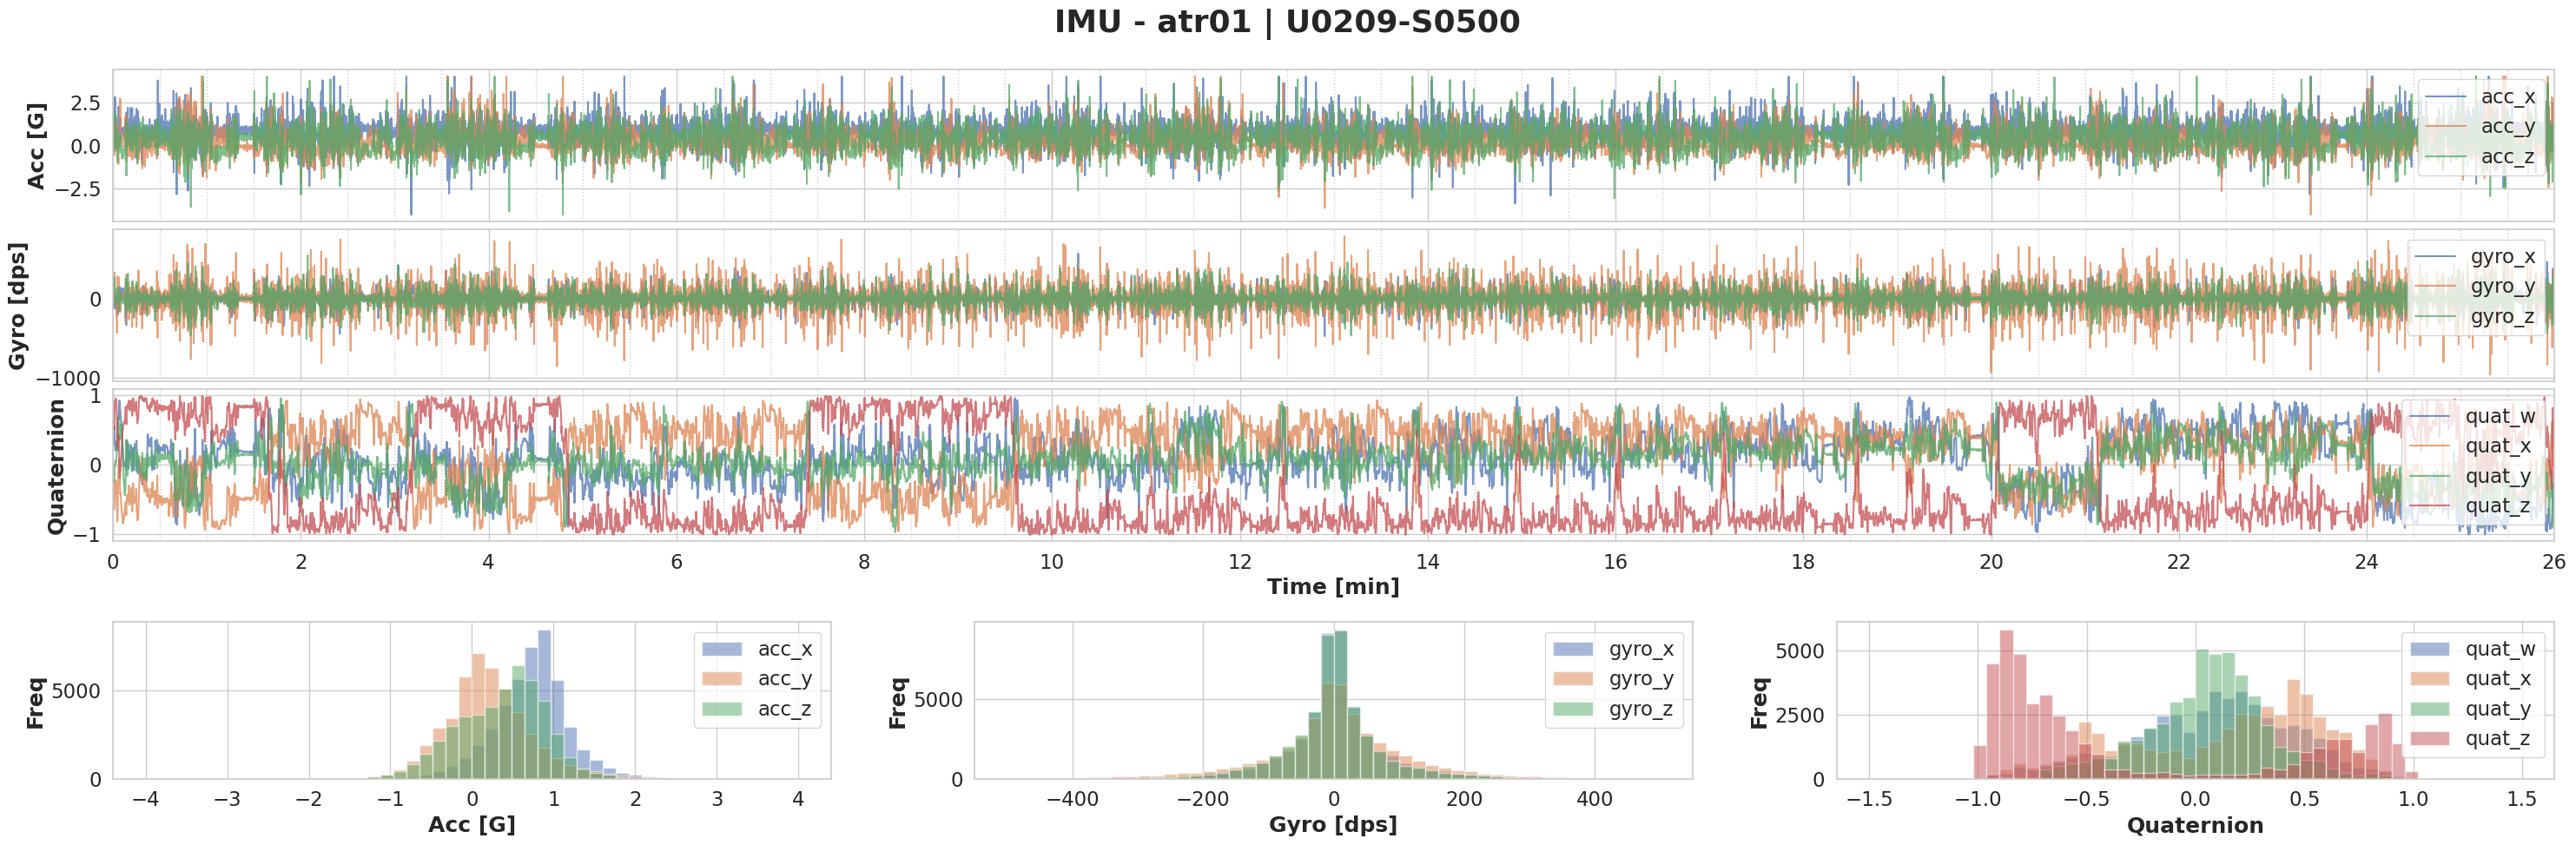

In [39]:
fig = plot_atr_qags(df, cfg)
fig.show()

**NOTE: Quaterion data is missing for some subjects. Please check user details before using them.**

### Tips: Load multiple IMU sequences at Once

Use `optk.data.load_imu()` to load IMU data from multiple devices, e.g., left and right wrist.
This function retuns sequences after time alignment.

In [40]:
# Make path list
paths = []
devices = ["atr01", "atr02"]

for device in devices:
    cfg.device = device
    paths.append(
        Path(
            cfg.dataset.stream.path.dir,
            cfg.dataset.stream.path.fname,
        )
    )

display(paths)

[PosixPath('/content/openpack-toolkit/samples/openpack/v1.0.0/U0209/atr/atr01/S0500.csv'),
 PosixPath('/content/openpack-toolkit/samples/openpack/v1.0.0/U0209/atr/atr02/S0500.csv')]

In [41]:
# Get only ACC data.
T, X = optk.data.load_imu(paths, use_acc=True, use_gyro=False, use_quat=False)
print(f"X={X.shape}, T={T.shape}")

X=(6, 46800), T=(46800,)


X's first dim = `["acc_x@atr01", "acc_y @atr01", "acc_x@atr01", "acc_x@atr02", "acc_y @atr02", "acc_x@atr02"] `

## 2-C: Keypoints (`kinect-2d-kpt`)

- [Docs](https://github.com/open-pack/openpack-toolkit/blob/main/docs/DATA_STREAM.md#6-kinect-2d-kpt)

2D keypoints are extracted from kinect recordings (front-view) using [open-mmlab/mmpose](https://github.com/open-mmlab/mmpose).
Keypoints data is provided in a MS COCO JSON file.

In [42]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.KINECT_2D_KPT_STREAM))

kind: dataset/stream/keypoint
name: kinect-2d-kpt
metadata:
  labels:
    app: openpack-benchmarks
    version: 1.0.0
    sensorType: keypoint/2d
path:
  dir: ${path.openpack.rootdir}/${user.name}/kinect/2d-kpt/mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2/single
  fname: ${session}.json
frameRate: 15
devices: null
acc: null
gyro: null
quat: null
nodes:
  0: nose
  1: left_eye
  2: right_eye
  3: left_ear
  4: right_ear
  5: left_shoulder
  6: right_shoulder
  7: left_elbow
  8: right_elbow
  9: left_wrist
  10: right_wrist
  11: left_hip
  12: right_hip
  13: left_knee
  14: right_knee
  15: left_ankle
  16: right_ankle



In [43]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.KINECT_2D_KPT_STREAM
cfg.session = "S0500"

path = Path(
    cfg.dataset.stream.path.dir,
    cfg.dataset.stream.path.fname,
)
print(path)

/content/openpack-toolkit/samples/openpack/v1.0.0/U0209/kinect/2d-kpt/mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2/single/S0500.json


In [44]:
# Load JSON file
with open(path, "r") as f:
    data = json.load(f)

In [45]:
data.keys()

dict_keys(['info', 'licenses', 'annotations', 'categories'])

In [46]:
data["info"]

{'year': 2022,
 'version': 'v0.2.0',
 'description': 'openpack/U0209/2d-kpt/mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2/single/S0500',
 'contributor': 'Naoya Yoshimura, Jaime Morales, Takuya Maekawa',
 'url': 'https://open-pack.github.io',
 'date_created': '2022/03/31'}

In [47]:
data["licenses"]

[{'id': 0,
  'name': 'Creative Commons Attribution Non Commercial Share Alike 4.0 International',
  'url': 'https://open-pack.github.io'}]

In [48]:
data["categories"]

[{'supercategory': 'person',
  'id': 1,
  'name': 'person',
  'keypoints': ['nose',
   'left_eye',
   'right_eye',
   'left_ear',
   'right_ear',
   'left_shoulder',
   'right_shoulder',
   'left_elbow',
   'right_elbow',
   'left_wrist',
   'right_wrist',
   'left_hip',
   'right_hip',
   'left_knee',
   'right_knee',
   'left_ankle',
   'right_ankle'],
  'skeleton': [[16, 14],
   [14, 12],
   [17, 15],
   [15, 13],
   [12, 13],
   [6, 12],
   [7, 13],
   [6, 7],
   [6, 8],
   [7, 9],
   [8, 10],
   [9, 11],
   [2, 3],
   [1, 2],
   [1, 3],
   [2, 4],
   [3, 5],
   [4, 6],
   [5, 7]]}]

In [49]:
data["annotations"][0]

{'id': 1648531508028000,
 'image_id': 1648531508028,
 'category_id': 1,
 'area': 60090.617,
 'bbox': [563.6, 294.1, 177.7, 338.1],
 'iscrowd': 0,
 'keypoints': [[629.8, 365.4, 0.99800366],
  [645.2, 387.5, 0.8853922],
  [629.8, 341.2, 0.6894177],
  [673.9, 361.0, 0.41215616],
  [607.7, 332.3, 0.41405165],
  [711.5, 405.2, 0.834655],
  [587.8, 409.6, 0.854016],
  [720.3, 495.7, 0.8856398],
  [581.2, 493.5, 0.89301157],
  [724.7, 577.4, 0.9030845],
  [579.0, 579.6, 0.8698651],
  [682.8, 579.6, 0.85565674],
  [612.1, 577.4, 0.84869087],
  [679.5, 671.3, 0.47250903],
  [617.6, 671.3, 0.3837408],
  [715.9, 606.1, 0.0980332],
  [590.0, 626.0, 0.13712923]],
 'num_keypoints': 17,
 'bbox_score': 0.9981534,
 'track_id': 47}

At last, let's visualize some keypoints sequence.

In [50]:
@noglobal()
def plot_kinect_2d_kpt(annots: dict, cfg: DictConfig):
    FS = 15
    seq_len = len(annots)

    # == Plot ==
    sns.set("notebook", "whitegrid")
    fig = plt.figure(figsize=(30, 2.5 * 3))
    gs_master = GridSpec(nrows=3, ncols=1)

    # -- Keypoints Location --
    data = [
        {
            "node": "nose",
            "idx": 0,
        },
        {
            "node": "Left Shoulder",
            "idx": 5,
        },
    ]
    xloc = np.arange(len(annots))
    for i, d in enumerate(data):
        title = d["node"]
        kpt_idx = d["idx"]

        X = np.array([annots[i]["keypoints"] for i in range(len(annots))])

        # -- Sequence (Acc / Gyro / Quat) --
        ax0 = fig.add_subplot(gs_master[i])
        ax1 = ax0.twinx()

        # prediction score
        ax1.fill_between(xloc, X[:, kpt_idx, 2], label="Score", color="C0", alpha=0.1)
        # Plot position
        for ch in range(2):
            ax0.plot(
                xloc,
                X[:, kpt_idx, ch],
                label="X-axis" if ch == 0 else "Y-axis",
                color=f"C{ch}",
                alpha=0.75,
            )

        xticks = np.arange(0, seq_len + 1, FS * 60 * 2)
        xticks_minor = np.arange(0, seq_len + 1, FS * 30)
        ax0.set_xticks(xticks)
        ax0.set_xticklabels(xticks // (FS * 60))
        ax0.set_xticks(xticks_minor, minor=True)
        ax0.set_xlim([0, seq_len])
        ax0.set_ylabel("Position [px]", fontweight="bold")

        ax1.set_yticks(np.arange(0, 1.1, 0.2))
        ax1.set_ylabel("Score", fontweight="bold")

        ax0.grid(True, which="minor", linestyle=":")
        ax0.legend(loc="upper left")
        ax1.legend(loc="upper right")
        ax0.set_title(f"{title} [IDX={kpt_idx}]", fontweight="bold", fontsize="x-large")

        if i == 1:
            ax0.set_xlabel("Time [min]", fontweight="bold")
        else:
            ax0.tick_params(
                labelbottom=False
            )

    # -- [2] Tracking Id --
    ax0 = fig.add_subplot(gs_master[2])
    X = np.array([annots[i]["track_id"] for i in range(len(annots))])
    ax0.scatter(xloc, X, color="C0", alpha=0.75, s=5)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // (FS * 60))
    ax0.set_xticks(xticks_minor, minor=True)
    ax0.set_xlim([0, seq_len])
    ax0.set_ylabel("Track ID", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")

    fig.suptitle(
        f"Kinect 2d-kpt | {cfg.user.name}-{cfg.session}",
        fontsize="x-large",
        fontweight="black")
    fig.tight_layout()
    return fig,

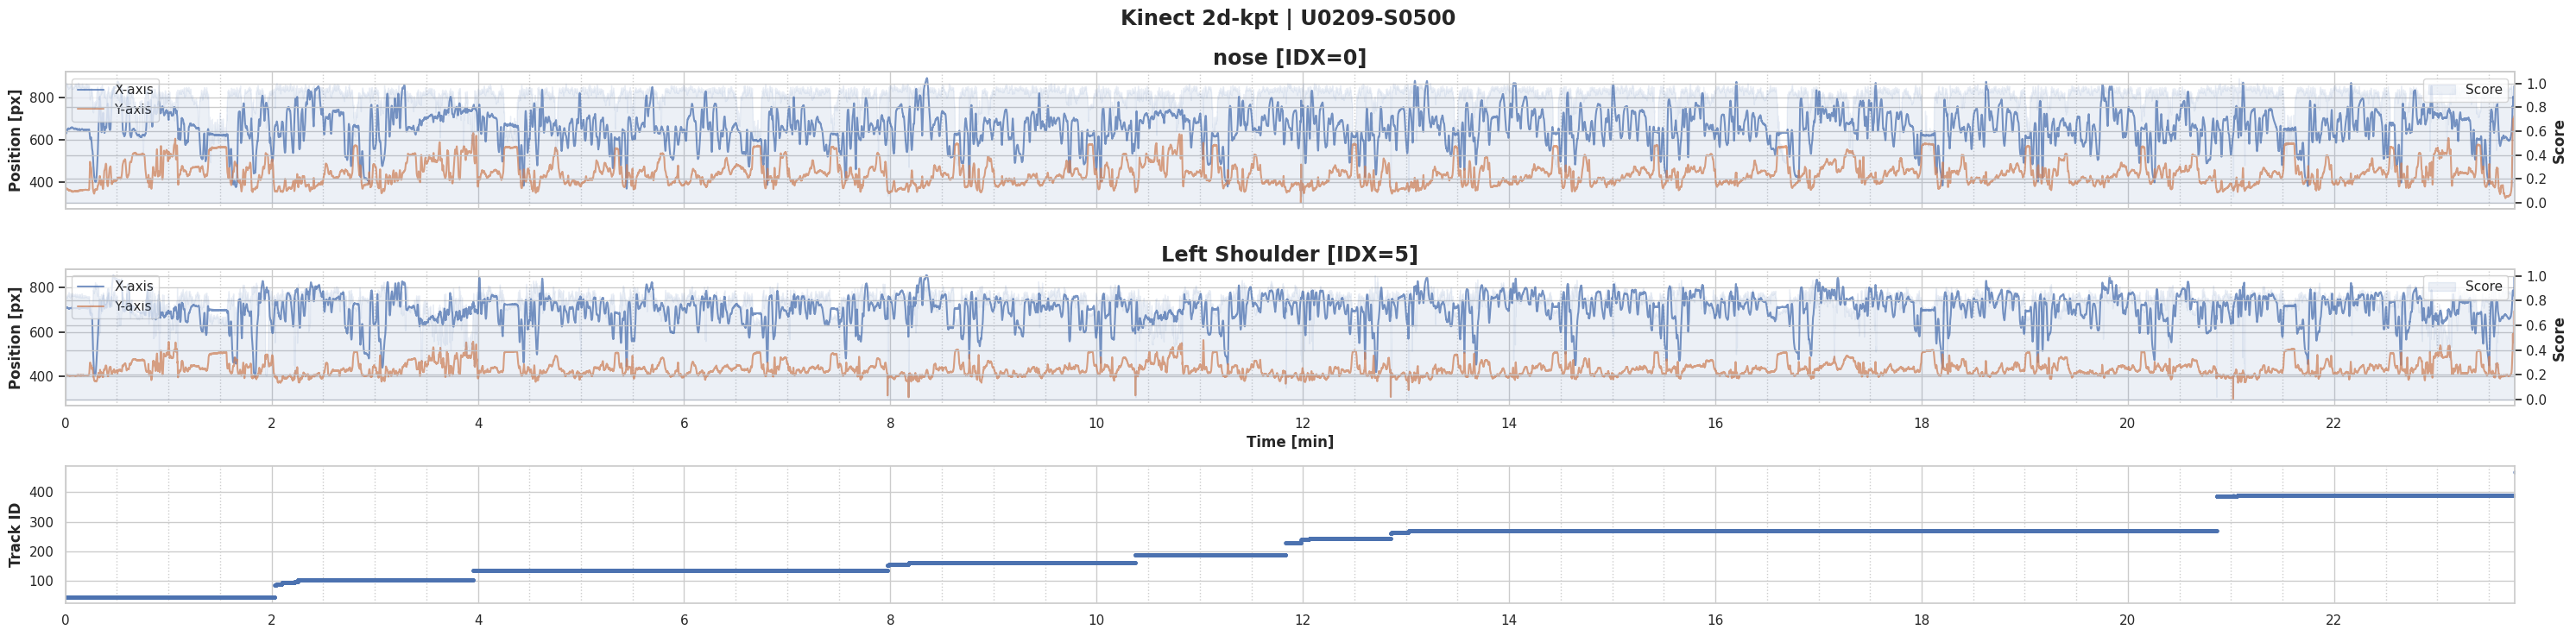

In [51]:
fig = plot_kinect_2d_kpt(data["annotations"], cfg)

### Tips: Directly Load Keypoints Sequence

The imported JSON file (MS COCO format) contains a lot of information but not everything is necessary for activity recognition.
You can use `optk.load_kyepoints()` to only get the keypoints sequence.
Skeleton with MS COCO format contains coordinates of 17 joints. Therefore the shape of X is `(X/Y/Score, Time, JOINT)`.

In [52]:
path = Path(
    cfg.dataset.stream.path.dir,
    cfg.dataset.stream.path.fname,
)
print(path)

T, X = optk.data.load_keypoints(path)
print(f"Timetamp [unixtime]: T={T.shape}")
print(f"Keypoints          : X={X.shape}")

/content/openpack-toolkit/samples/openpack/v1.0.0/U0209/kinect/2d-kpt/mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2/single/S0500.json
Timetamp [unixtime]: T=(21376,)
Keypoints          : X=(3, 21376, 17)


## 2-D: Data from E4 (Acceratation, BVP, EDA, and Temperature; `e4-XXX`)

- [Docs](https://github.com/open-pack/openpack-toolkit/blob/main/docs/DATA_STREAM.md#2-e4-acc)

Subjects wore 2 [Empatica E4](https://www.empatica.com/en-int/research/e4/) sensors.
These sensors recorded acceratation, BVP (Blood Volume Pulse), EDA, and temperature sequences. These data can be used to predict work operations in the challenge.
The data is saved as CSV file.

Let's load and visualize data from e401 (E4 sensor attached to the right wrist).

### E4 - Acc

In [53]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.E4_ACC_STREAM))

kind: dataset/stream/e4
name: e4-acc
metadata:
  labels:
    app: openpack
    version: 1.0.0
    sensorType: ACC
path:
  dir: ${path.openpack.rootdir}/${user.name}/e4/${device}/acc
  fname: ${session}.csv
frameRate: 32
devices:
- e401
- e402
acc: null
gyro: null
quat: null
nodes: ???



In [54]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.E4_ACC_STREAM
cfg.user = optk.configs.users.U0209
cfg.session = "S0500"
cfg.device = "e401"

path = Path(
    cfg.dataset.stream.path.dir,
    cfg.dataset.stream.path.fname,
)
print(path)

/content/openpack-toolkit/samples/openpack/v1.0.0/U0209/e4/e401/acc/S0500.csv


In [55]:
# Load CSV file
df_e4_acc = pd.read_csv(path)

In [56]:
df_e4_acc

,time,acc_x,acc_y,acc_z
0,1648531510031,-0.041426,-0.092412,0.011153
1,1648531510062,-0.041426,-0.092412,0.011153
2,1648531510093,-0.043019,-0.092412,0.007967
3,1648531510124,-0.041426,-0.094005,0.007967
4,1648531510156,-0.041426,-0.092412,0.007967
...,...,...,...,...
45498,1648532931865,-0.052579,-0.095598,-0.001593
45499,1648532931896,-0.062139,-0.090818,-0.004780
45500,1648532931928,-0.052579,-0.079665,-0.001593
45501,1648532931959,-0.054172,-0.074885,-0.001593


### E4 - BVP

In [57]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.E4_BVP_STREAM))

kind: dataset/stream/e4
name: e4-bvp
metadata:
  labels:
    app: openpack
    version: 1.0.0
    sensorType: Blood Volume Pulse (BVP)
path:
  dir: ${path.openpack.rootdir}/${user.name}/e4/${device}/bvp
  fname: ${session}.csv
frameRate: 64
devices:
- e401
- e402
acc: null
gyro: null
quat: null
nodes: ???



In [58]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.E4_BVP_STREAM
cfg.user = optk.configs.users.U0209
cfg.session = "S0500"
cfg.device = "e401"

path = Path(
    cfg.dataset.stream.path.dir,
    cfg.dataset.stream.path.fname,
)
print(path)

/content/openpack-toolkit/samples/openpack/v1.0.0/U0209/e4/e401/bvp/S0500.csv


In [59]:
# Load CSV file
df_e4_bvp = pd.read_csv(path)

In [60]:
df_e4_bvp

,time,bvp
0,1648531510011,-110.82
1,1648531510027,-111.75
2,1648531510043,-111.07
3,1648531510058,-107.78
4,1648531510074,-101.50
...,...,...
91002,1648532931929,67.25
91003,1648532931944,63.34
91004,1648532931960,56.48
91005,1648532931975,47.47


### E4 - EDA

In [61]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.E4_EDA_STREAM))

kind: dataset/stream/e4
name: e4-eda
metadata:
  labels:
    app: openpack
    version: 1.0.0
    sensorType: EDA
path:
  dir: ${path.openpack.rootdir}/${user.name}/e4/${device}/eda
  fname: ${session}.csv
frameRate: 4
devices:
- e401
- e402
acc: null
gyro: null
quat: null
nodes: ???



In [62]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.E4_EDA_STREAM
cfg.user = optk.configs.users.U0209
cfg.session = "S0500"
cfg.device = "e401"

path = Path(
    cfg.dataset.stream.path.dir,
    cfg.dataset.stream.path.fname,
)
print(path)

/content/openpack-toolkit/samples/openpack/v1.0.0/U0209/e4/e401/eda/S0500.csv


In [63]:
# Load CSV file
df_e4_eda = pd.read_csv(path)

In [64]:
df_e4_eda

,time,eda
0,1648531510238,0.589199
1,1648531510488,0.585357
2,1648531510738,0.585357
3,1648531510988,0.587919
4,1648531511238,0.586638
...,...,...
5682,1648532930914,4.438311
5683,1648532931164,4.442153
5684,1648532931414,4.448557
5685,1648532931664,4.460085


### E4 - Temp

In [65]:
# NOTE: Path template is defined in `path` attribute.
print(OmegaConf.to_yaml(optk.configs.datasets.streams.E4_TEMP_STREAM))

kind: dataset/stream/e4
name: e4-temp
metadata:
  labels:
    app: openpack
    version: 1.0.0
    sensorType: temperature
path:
  dir: ${path.openpack.rootdir}/${user.name}/e4/${device}/temp
  fname: ${session}.csv
frameRate: 4
devices:
- e401
- e402
acc: null
gyro: null
quat: null
nodes: ???



In [66]:
# Set parameters to the config object.
cfg.dataset.stream = optk.configs.datasets.streams.E4_TEMP_STREAM
cfg.user = optk.configs.users.U0209
cfg.session = "S0500"
cfg.device = "e401"

path = Path(
    cfg.dataset.stream.path.dir,
    cfg.dataset.stream.path.fname,
)
print(path)

/content/openpack-toolkit/samples/openpack/v1.0.0/U0209/e4/e401/temp/S0500.csv


In [67]:
# Load CSV file
df_e4_temp = pd.read_csv(path)

In [68]:
df_e4_temp

,time,temp
0,1648531510238,33.00
1,1648531510488,33.00
2,1648531510738,33.00
3,1648531510988,33.00
4,1648531511238,33.03
...,...,...
5682,1648532930914,37.31
5683,1648532931164,37.31
5684,1648532931414,37.29
5685,1648532931664,37.29


Next, we visualize loaded sensor stream data.

In [69]:
@noglobal()
def plot_e4_all(
        data: dict,
        user: str,
        session: str,
        device: str,
        version=None,
        xlim=None,
        figsize=(30, 7)):

    E4_SENSORS = ["acc", "bvp", "eda", "temp"]

    # == Plot ==
    fig = plt.figure(figsize=(30, 3 * 5))
    gs_master = GridSpec(nrows=2, ncols=1, height_ratios=[4, 1])
    gs_line = GridSpecFromSubplotSpec(
        nrows=4, ncols=1, subplot_spec=gs_master[0], hspace=0.05)
    gs_hist = GridSpecFromSubplotSpec(nrows=1, ncols=4, subplot_spec=gs_master[1])

    metadata = {
        "acc": {
            "label": "Acc [G]",
            "cols": ["acc_x", "acc_y", "acc_z"],
            "lim": [-2.0, 2.0],
            "fs": 32,
        },
        "bvp": {
            "label": "BVP [mmHg]",
            "cols": ["bvp"],
            "lim": [-2000.0, 2000.0],
            "fs": 64,
        },
        "eda": {
            "label": "EDA\n[microsiemens]",
            "cols": ["eda"],
            "lim": [0.0, 25.0],
            "fs": 4,
        },
        "temp": {
            "label": "Temp [°C]",
            "cols": ["temp"],
            "lim": [30.0, 40.0],
            "fs": 4,
        },
    }
    # xloc = df.index.values
    for i, sensor in enumerate(E4_SENSORS):
        d = metadata[sensor]

        df = data[sensor]
        cols = d["cols"]
        ylabel = d["label"]
        lim = d["lim"]
        fs = d["fs"]

        X = df[cols].values.T
        xloc = df.index.values
        seq_len = len(xloc)

        # -- Sequence (Acc / Gyro / Quat) --
        ax0 = fig.add_subplot(gs_line[i])
        for ch, col_name in enumerate(cols):
            ax0.plot(xloc, X[ch], label=col_name, color=f"C{ch}", alpha=0.75)

        xticks = np.arange(0, seq_len + 1, fs * 60)
        xticks_minor = np.arange(0, seq_len + 1, fs * 30)
        ax0.set_xticks(xticks)
        ax0.set_xticklabels(xticks // (fs * 60))
        ax0.set_xticks(xticks_minor, minor=True)
        ax0.set_xlim([0, seq_len])

        ax0.set_ylabel(ylabel, fontweight="bold")
        ax0.grid(True, which="minor", linestyle=":")
        ax0.legend(loc="upper right")

        if i == 3:
            ax0.set_xlabel("Time [min]", fontweight="bold")
        else:
            ax0.tick_params(
                labelbottom=False
            )

        # -- Histgram --
        ax1 = fig.add_subplot(gs_hist[i])
        for ch, col_name in enumerate(cols):
            ax1.hist(
                X[ch],
                range=lim,
                bins=50,
                label=col_name,
                color=f"C{ch}",
                alpha=0.50)

        ax1.set_xlabel(ylabel, fontweight="bold")
        ax1.set_ylabel("Freq", fontweight="bold")
        ax1.legend(loc="upper right")

    fig.suptitle(
        f"E4 - {device} | {user}-{session}",
        fontsize="x-large",
        fontweight="black")
    fig.tight_layout()
    return fig


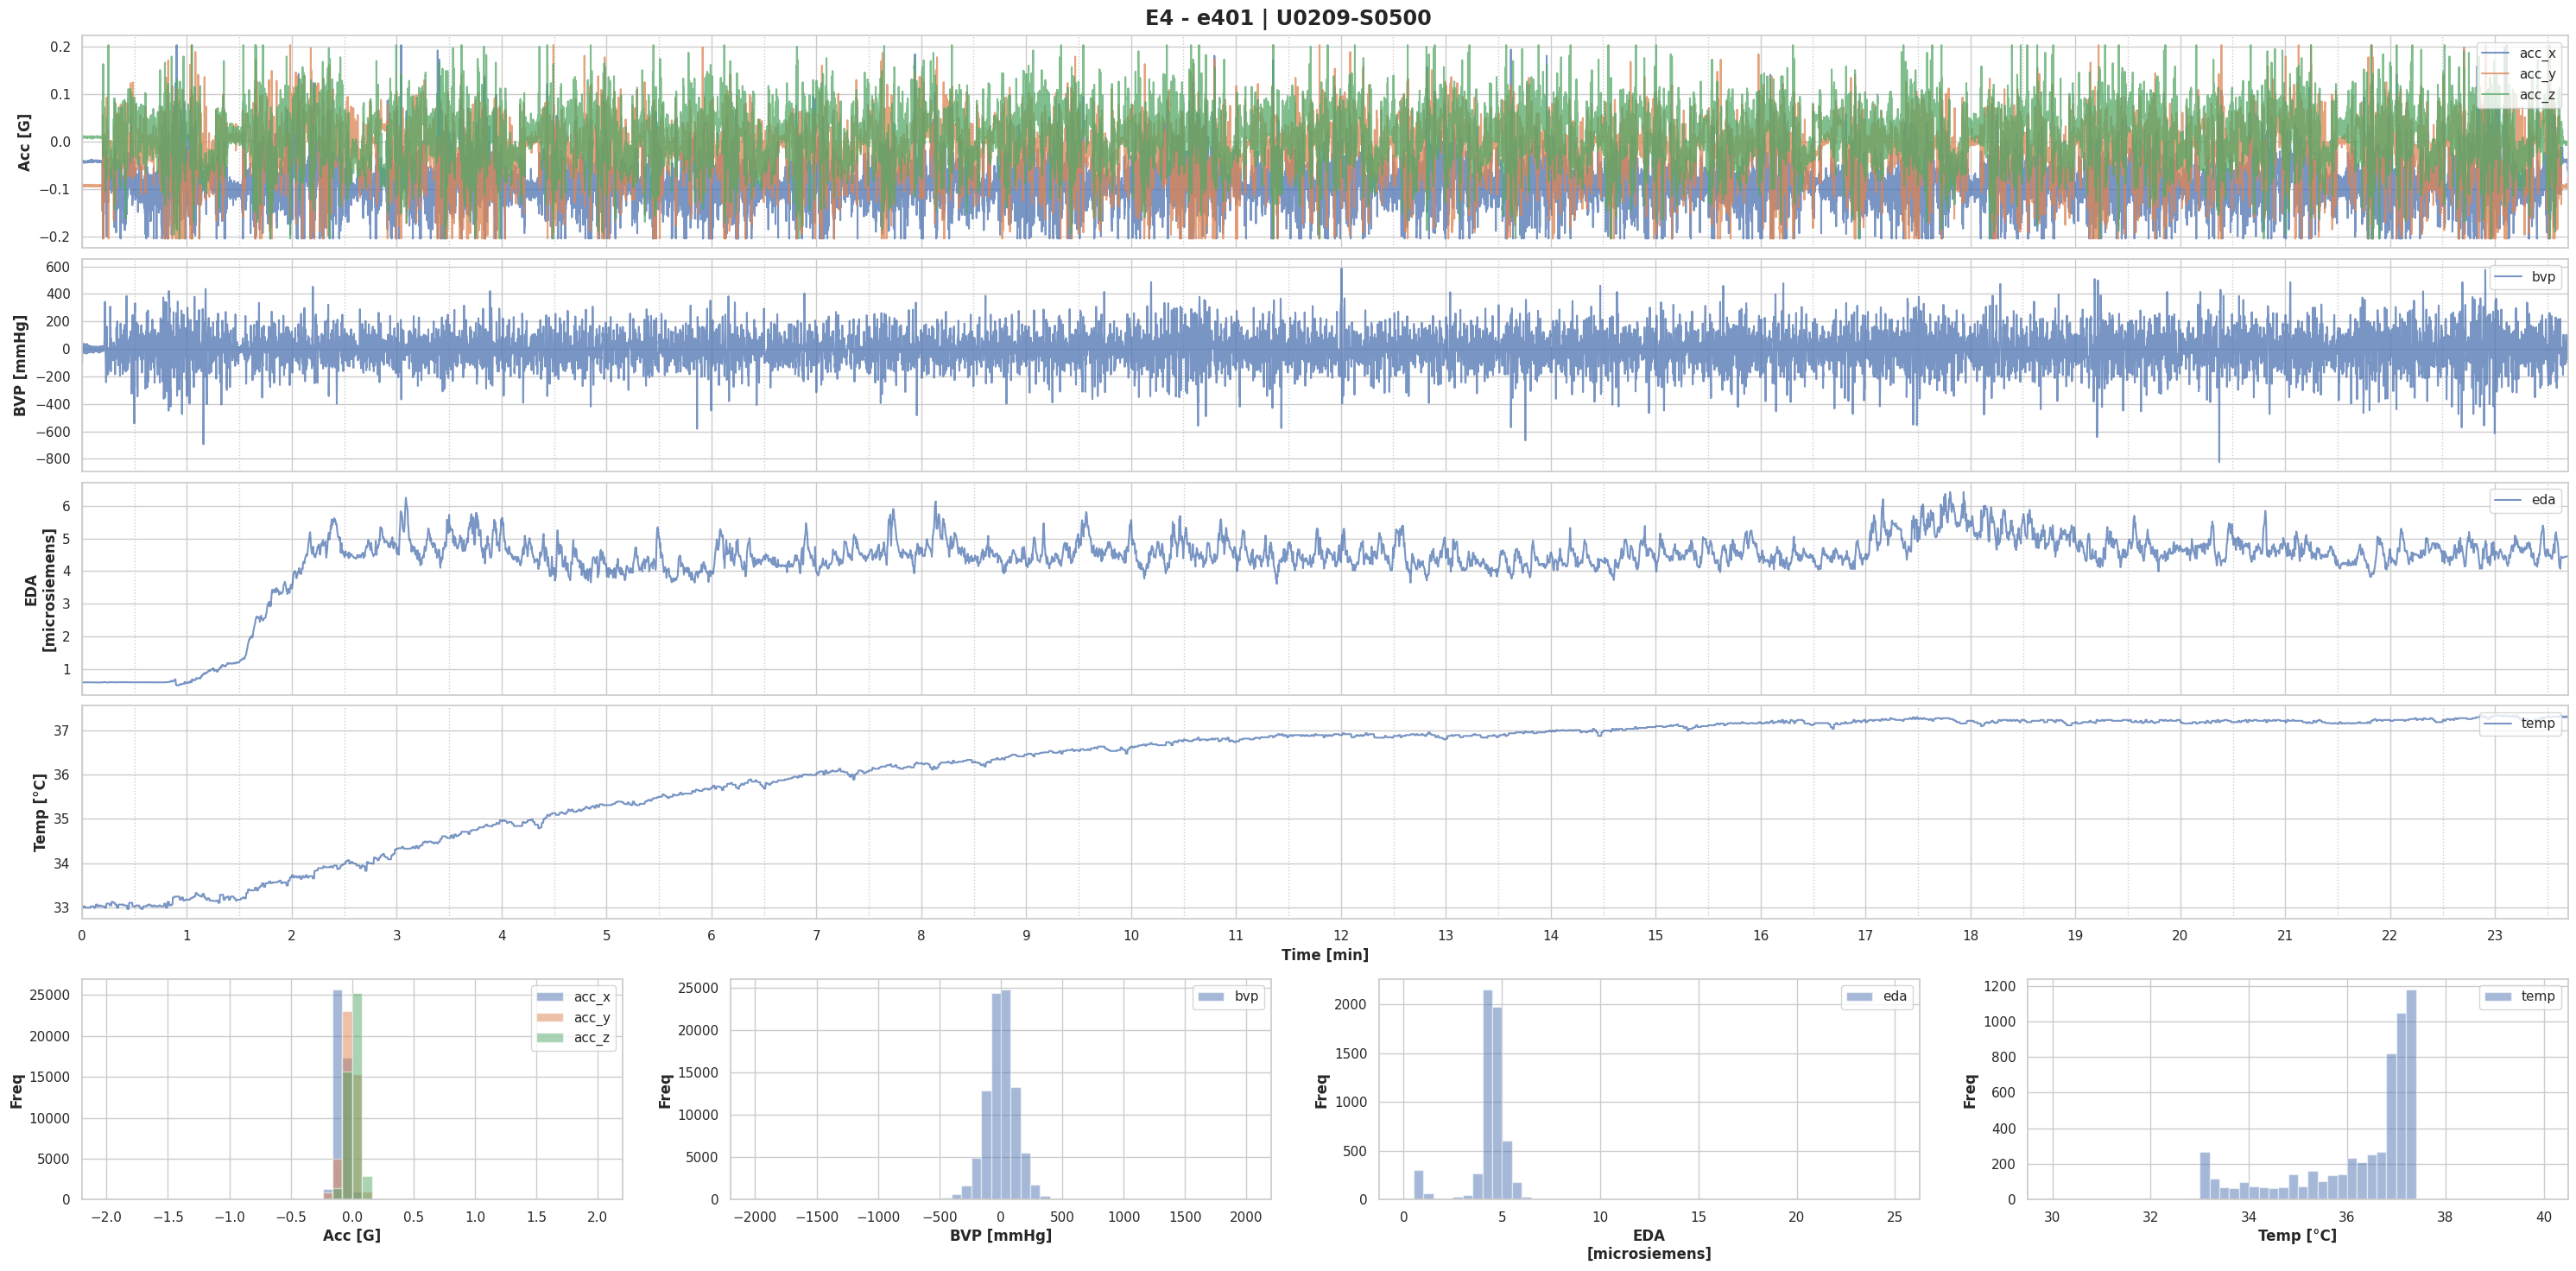

In [70]:
data = {
    "acc": df_e4_acc,
    "bvp": df_e4_bvp,
    "eda": df_e4_eda,
    "temp": df_e4_temp,
}

fig = plot_e4_all(data, cfg.user.name, cfg.session, cfg.device)
fig.show()

## Next Step

Next step might be building your models to predict work activities!
OpenPack team prepare some tutorial to build models using PyTorch.
Please visit [GitHub: opnepack-torch](https://github.com/open-pack/openpack-torch)!
I hope you will enjoy this competition!